# Logistic Regression for df_merged_neg_15x15_final

# Table of Contents<a class="anchor" id="Contents"></a>
* [Load Packages](#Packages)
* [Load Dataset](#Dataset)
    * [Train Test Validation Split](#Train_Test_Validation_Split)
* [Functions](#Functions)
* [Logistic Regression](#LG)
    * [Run the Model](#Run_LG)
    * [ROC Curve and Precision-Recall Curve](#Curve_LG)
    * [Results](#Results_LG)

# Load Packages<a class="anchor" id="Packages"></a>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import RocCurveDisplay, auc, roc_auc_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import silhouette_score
from keras.optimizers import Adam
import random
import csv
import statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [1]:
from joblib import load

best_lg = load('best_model/best_lg_neg.joblib')
best_lg_pc = load('best_model/best_lg_neg_pc.joblib')

* [Table of Contents](#Contents)

# Load Dataset<a class="anchor" id="Dataset"></a>

In [3]:
df_merged_neg_15x15 = pd.read_csv('data/df_merged_neg_15x15_final.csv')
df_merged_neg_15x15

,time,site,BBP_1x1_median,CDM_1x1_median,SPM_1x1_median,KD490_1x1_median,ZSD_1x1_median,CHL_1x1_median,BBP_1x1_mean,CDM_1x1_mean,...,KD490_15x15_q1,ZSD_15x15_q1,CHL_15x15_q1,BBP_15x15_q3,CDM_15x15_q3,SPM_15x15_q3,KD490_15x15_q3,ZSD_15x15_q3,CHL_15x15_q3,riskLevelLabel
0,2020-01-22,ukd4305-43260,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
1,2020-02-17,ukk3106-27200,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
2,2020-02-29,ukk4304-34200,0.0,0.0,0.278289,0.905697,0.381887,0.191762,0.0,0.0,...,0.912616,0.381887,0.209223,0.0,0.0,0.278289,0.908233,0.381887,0.198058,1
3,2020-03-01,ukk4305-25400,0.0,0.0,0.179310,0.897213,0.466615,0.156853,0.0,0.0,...,0.903999,0.464243,0.170801,0.0,0.0,0.179310,0.899777,0.466615,0.162112,1
4,2020-03-12,uke1200-08100,0.0,0.0,0.239333,0.908982,0.367827,0.207890,0.0,0.0,...,0.915927,0.367827,0.226820,0.0,0.0,0.239333,0.911528,0.367827,0.214716,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187106,2022-11-08,ukj3400-17700,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
187107,2022-12-02,ukk3103-29500,0.0,0.0,0.117570,0.892609,0.633440,0.143064,0.0,0.0,...,0.899428,0.633440,0.156091,0.0,0.0,0.117570,0.895108,0.633440,0.147761,1
187108,2022-12-07,ukk3103-29100,0.0,0.0,0.111443,0.906253,0.398421,0.198937,0.0,0.0,...,0.909478,0.388881,0.193924,0.0,0.0,0.108026,0.908791,0.401596,0.205469,1
187109,2022-12-08,ukk3103-29100,0.0,0.0,0.106985,0.894695,0.525795,0.148640,0.0,0.0,...,0.901454,0.524903,0.161904,0.0,0.0,0.105991,0.897206,0.527476,0.153521,0


In [4]:
counts_normalized = df_merged_neg_15x15['riskLevelLabel'].value_counts(normalize=True)
counts_normalized

0    0.971797
1    0.028203
Name: riskLevelLabel, dtype: float64

## Train Test Validation Split<a class="anchor" id="Train_Test_Validation_Split"></a>

In [5]:
train_labels_mean_zero = pd.read_csv('data/train_labels_mean_zero.csv')[['time', 'site']]
train_labels_mean_zero

,time,site
0,2021-05-25,ukk4305-25800
1,2022-07-04,ukk4305-25800
2,2022-08-08,ukk3105-31450
3,2022-08-27,ukk2206-20800
4,2020-06-08,uke1301-09020
...,...,...
112261,2021-07-19,ukj4210-12660
112262,2021-05-10,ukk4200-23200
112263,2020-08-10,ukk3104-33500
112264,2021-09-08,ukk1202-35700


In [6]:
validation_labels_mean_zero = pd.read_csv('data/validation_labels_mean_zero.csv')[['time', 'site']]
validation_labels_mean_zero

,time,site
0,2020-07-02,ukj3400-17400
1,2022-08-27,ukk3106-32200
2,2021-05-06,ukk4307-33900
3,2021-05-20,ukk4304-34100
4,2021-06-04,ukk3104-33200
...,...,...
37417,2021-07-28,ukk3103-29800
37418,2021-05-02,uke2206-07200
37419,2022-09-08,ukk4301-21800
37420,2021-07-18,ukj2403-15900


In [7]:
test_labels_mean_zero = pd.read_csv('data/test_labels_mean_zero.csv')[['time', 'site']]
test_labels_mean_zero

,time,site
0,2022-09-21,ukk3106-32100
1,2020-08-08,ukh1407-10750
2,2020-09-20,ukd4200-42100
3,2022-07-06,ukk2206-20900
4,2021-08-24,ukk4305-26100
...,...,...
37418,2021-09-22,ukj2402-15680
37419,2021-08-14,ukk3104-33500
37420,2022-05-20,ukk4305-25600
37421,2022-06-25,ukj3400-18000


In [8]:
# Train test validation split
df_train = df_merged_neg_15x15.merge(train_labels_mean_zero, on=['time', 'site'], how='inner')
df_val = df_merged_neg_15x15.merge(validation_labels_mean_zero, on=['time', 'site'], how='inner')
df_test = df_merged_neg_15x15.merge(test_labels_mean_zero, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_val.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_val = df_val.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_val = df_val
X_test = df_test

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Validation X Shape:', X_val.shape)
print('Validation y Shape:', y_val.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (112266, 192)
Training y Shape: (112266,)
Validation X Shape: (37422, 192)
Validation y Shape: (37422,)
Testing X Shape: (37423, 192)
Testing y Shape: (37423,)


* [Table of Contents](#Contents)

# Functions<a class="anchor" id="Functions"></a>

In [9]:
def pr_curve(model, X_test, y_test):
    y_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    prc_auc = auc(recall, precision)
    fig, ax = plt.subplots()
    ax.plot(recall, precision, label='Precision recall curve (area = %0.2f)' % prc_auc)
    ax.axhline(y=counts_normalized[1], color='gray', linestyle='--', label='baseline')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc="lower right")
    plt.show()
    return fig

In [10]:
def plot_roc(model, X_test, y_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Curve')
    ax.legend(loc="lower right")
    plt.show()
    return fig

In [29]:
def cm(model,X_test,y_test):
    cm = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    cm.plot
    # plt.savefig('results/CM_mean_15x15_lg_PCA.png')

In [12]:
def save_result(model,X_test,y_test):
    y_pred = model.predict(X_test)
    ACC = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    AUC_ROC = auc(fpr, tpr)
    PRE = precision_score(y_test, y_pred)
    REC = recall_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    AUC_PRC = auc(recall, precision)
    F1 = f1_score(y_test, y_pred)
    return ACC, AUC_ROC, PRE, REC, AUC_PRC, F1

* [Table of Contents](#Contents)

# Logistic Regression<a class="anchor" id="LG"></a>

In [9]:
def lg_model(X_train, y_train, X_val, y_val):
#     params = {'penalty': ['l1', 'l2', 'elasticnet'], # regularization types
#               'C': [0.001, 0.01, 0.1, 1, 10], # λ
#               'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]  # only relevant for 'elasticnet'
#              }
    params = {'penalty': ['elasticnet'], # regularization types
              'C': [0.01, 0.1], # λ
              'l1_ratio': [0.25, 0.5, 0.75]  # only relevant for 'elasticnet'
             }
    best_f1 = 0
    best_params = {}
    for penalty in params['penalty']:
        for C in params['C']:
            for l1_ratio in params['l1_ratio']:
                lg = LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, 
                                       random_state = 100, #specify the random_state
                                       solver = 'saga', class_weight = 'balanced',
                                       n_jobs = -1, #use all cpu cores
                                       max_iter = 5000 #give more iteration for model to converge
                                       )
                temp_model = lg.fit(X_train, y_train)
                y_val_pred = lg.predict(X_val)
                f1 = f1_score(y_val, y_val_pred)
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'penalty': penalty, 'C': C, 'l1_ratio': l1_ratio}
                    best_lg = temp_model
        
    print('Best Hyperparameters:', best_params)
    return best_lg

## Run the Model<a class="anchor" id="Run_LG"></a>

### Select the best hyperparameter on validation data

Best Hyperparameters: {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio': 0.1}

In [10]:
best_lg = lg_model(X_train, y_train, X_val, y_val)

C:\ANACONDA\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ANACONDA\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Hyperparameters: {'penalty': 'elasticnet', 'C': 0.1, 'l1_ratio': 0.75}


C:\ANACONDA\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
from joblib import dump

dump(best_lg, 'best_model/best_lg_neg.joblib')

['best_model/best_lg_neg.joblib']

## ROC Curve and Precision-Recall Curve<a class="anchor" id="Curve_LG"></a>

### ROC Curve

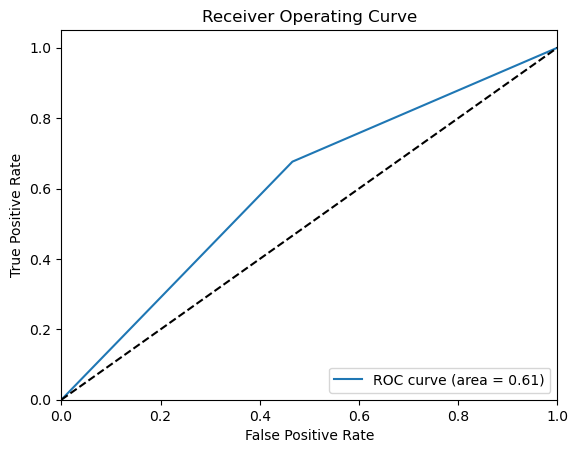

In [13]:
roc_lg = plot_roc(best_lg, X_test, y_test)

In [23]:
roc_lg.savefig('results/15_neg_lg/ROC_neg_15x15_lg.png')

### Precision-Recall Curve

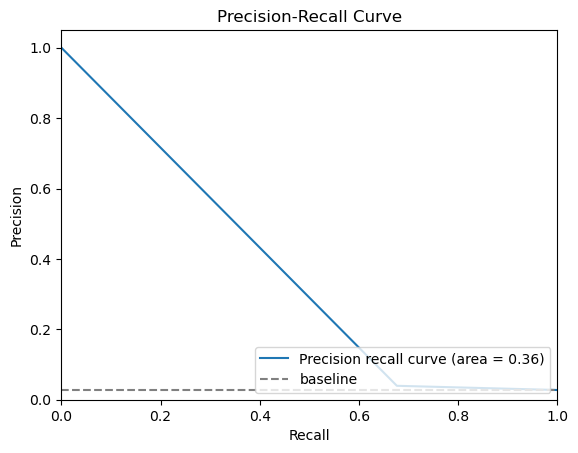

In [14]:
prc_lg = pr_curve(best_lg, X_test, y_test)

In [24]:
prc_lg.savefig('results/15_neg_lg/PRC_neg_15x15_lg.png')

## Results<a class="anchor" id="Results_LG"></a>

LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.75, max_iter=5000,
                   n_jobs=-1, penalty='elasticnet', random_state=100,
                   solver='saga') 
On test data, Accuracy: 0.54
On test data, Precision: 0.04
On test data, Recall: 0.68
On test data, f1 score: 0.07 


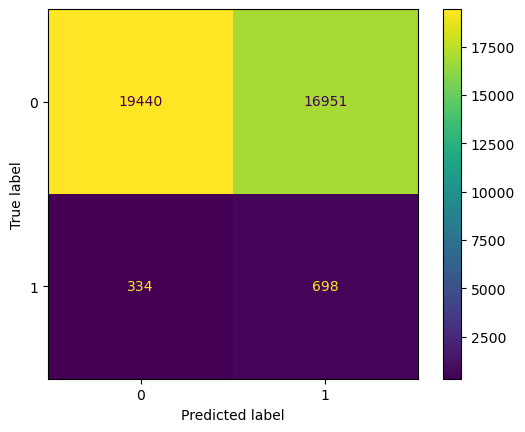

In [26]:
cm(best_lg, X_test, y_test)

In [33]:
results_df_lg = pd.DataFrame([['Logistic Regression', 'df_merged_neg_15x15', *save_result(best_lg,X_test,y_test)]],
                             columns=['Model', 'Sub-Model', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_lg

,Model,Sub-Model,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Logistic Regression,df_merged_neg_15x15,0.538118,0.605277,0.039549,0.676357,0.362415,0.074728


In [34]:
results_df_lg.to_csv('results/15_neg_lg/results_neg_15x15_lg.csv')

* [Table of Contents](#Contents)

In [18]:
## Fit X_train, X_val, X_test with the PCA
pca = PCA(n_components = 5, random_state = 100)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_val_pc = pca.transform(X_val)
X_test_pc = pca.transform(X_test)
print('the shape of X_train after PCA:',X_train_pc.shape,'the shape of y train:',y_train.shape)
print('the shape of X_val after PCA:',X_val_pc.shape,'the shape of y train:',y_val.shape)
print('the shape of X_test after PCA:',X_test_pc.shape,'the shape of y test:',y_test.shape)

the shape of X_train after PCA: (112266, 5) the shape of y train: (112266,)
the shape of X_val after PCA: (37422, 5) the shape of y train: (37422,)
the shape of X_test after PCA: (37423, 5) the shape of y test: (37423,)


In [13]:
def lg_model_pc(X_train, y_train, X_val, y_val):
    params = {'penalty': ['elasticnet'], # regularization types
              'C': [0.01, 0.1], # λ
              'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]  # only relevant for 'elasticnet'
             }
    best_f1 = 0
    best_params = {}
    for penalty in params['penalty']:
        for C in params['C']:
            for l1_ratio in params['l1_ratio']:
                lg = LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, 
                                       random_state = 100, #specify the random_state
                                       solver = 'saga', class_weight = 'balanced',
                                       n_jobs = -1, #use all cpu cores
                                       max_iter = 5000 #give more iteration for model to converge
                                       )
                temp_model = lg.fit(X_train, y_train)
                y_val_pred = lg.predict(X_val)
                f1 = f1_score(y_val, y_val_pred)
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'penalty': penalty, 'C': C, 'l1_ratio': l1_ratio}
                    best_lg = temp_model

    print('Best Hyperparameters:', best_params)
    return best_lg

In [14]:
best_lg_pc = lg_model_pc(X_train_pc, y_train, X_val_pc, y_val)

C:\ANACONDA\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ANACONDA\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Hyperparameters: {'penalty': 'elasticnet', 'C': 0.1, 'l1_ratio': 0.75}


C:\ANACONDA\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
from joblib import dump

dump(best_lg_pc, 'best_model/best_lg_neg_pc.joblib')

['best_model/best_lg_neg_pc.joblib']

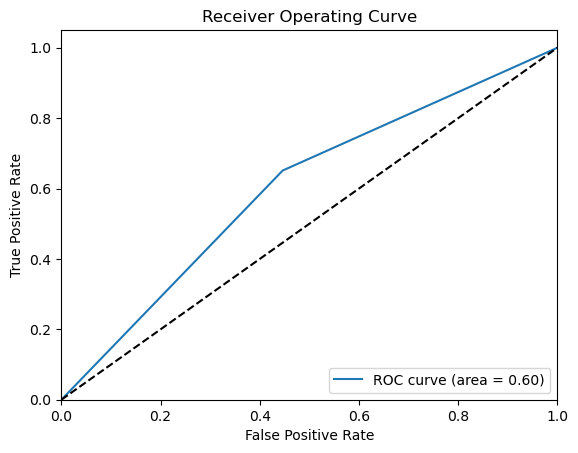

In [19]:
roc_lg_pc = plot_roc(best_lg_pc, X_test_pc, y_test)

In [31]:
roc_lg_pc.savefig('results/15_neg_lg/PCA/ROC_neg_15x15_lg_pc.png')

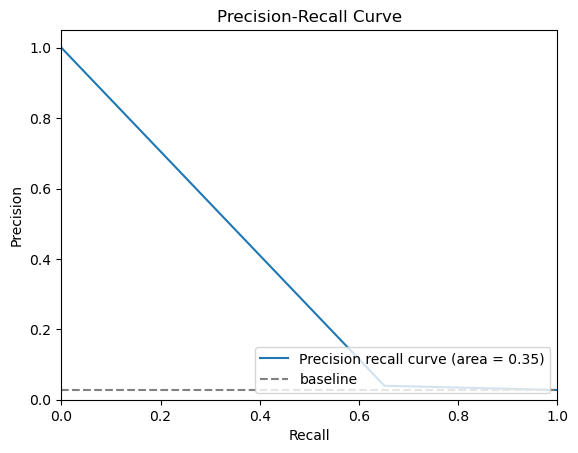

In [20]:
prc_lg_pc = pr_curve(best_lg_pc, X_test_pc, y_test)

In [32]:
prc_lg_pc.savefig('results/15_neg_lg/PCA/PRC_neg_15x15_lg_pc.png')

LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.75, max_iter=5000,
                   n_jobs=-1, penalty='elasticnet', random_state=100,
                   solver='saga') 
On test data, Accuracy: 0.56
On test data, Precision: 0.04
On test data, Recall: 0.65
On test data, f1 score: 0.07 


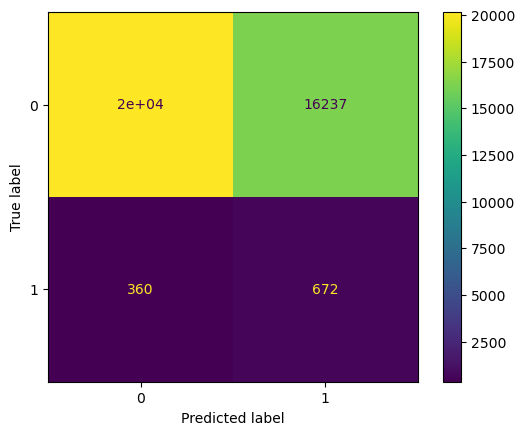

In [30]:
cm(best_lg_pc, X_test_pc, y_test)

In [35]:
results_df_lg_pc = pd.DataFrame([['Logistic Regression', 'df_merged_neg_15x15 with PCA', *save_result(best_lg_pc,X_test_pc,y_test)]],
                             columns=['Model', 'Sub-Model', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_lg_pc

,Model,Sub-Model,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Logistic Regression,df_merged_neg_15x15 with PCA,0.556503,0.602491,0.039742,0.651163,0.350262,0.074912


In [36]:
results_df_lg_pc.to_csv('results/15_neg_lg/PCA/results_neg_15x15_lg_pc.csv')